# implicit

In [ ]:
'''
1. functions ndcg and get_top_k
'''

def ndcg(recs, gt):
    '''
    input: 1. recs = recommendation list for one user.
                recs = 
           2. gt = ratings of a user in the test set.
                gt = a dictionary of lists with (key = each user) and (value = a list of items for this user)
           
    output: ndcg for a MODEL (not for each user) with a specific setting.
    '''
    Q, S = 0.0, 0.0
    for u, vs in gt.items():
        rec = recs.get(u, [])
        if not rec:
            continue

        idcg = sum([1.0 / math.log(i + 2, 2) for i in range(len(vs))])
        dcg = 0.0
        for i, r in enumerate(rec):
            if r not in vs:
                continue
            rank = i + 1
            dcg += 1.0 / math.log(rank + 1, 2)
        ndcg = dcg / idcg
        S += ndcg
        Q += 1
    return S / Q

def get_top_k(k,user,songs_of_user_in_trainDict,result):
    '''
    input:  k = number of recommendations to be made
            user = user's id
            songs_of... = a user's songs in the train set
            result = a dict of dicts of estimations; e.g. result[user][item] = estimation
    
    output: rec = a ranked list (in descending. i.e. the first entry is top-1) of recommendations of length k for this user.
    '''
    estimations = result[user]
    songs, ests = list(estimations.keys()), list(estimations.values())
    idx = np.argsort(-np.array(ests))
    recs = []
    for i in idx:
        song = songs[i]
        if song not in songs_of_user_in_trainDict:
            recs.append(song)
        if len(recs) == k:
            break
    return rec


'''
2. code excerpts in the run() function 
'''
# compute nDCG.
k=n_recommendations
gt = validDict         # validDict is nothing but a dictionary of lists e.g. validDict[user] = [item1, item2,...] in test set

# fill in the recommendation list for each user
recs = defaultdict(list)
for user in validDict:
    songs_of_user_in_trainDict = list(trainDict[user].keys())
    recs[user] = get_top_k(k,user,songs_of_user_in_trainDict,result)
val = ndcg(recs,gt)
print('nDCG for rank={} and lambda={} is : {}'.format(n_factors, lam, val))

# Setup

In [37]:
import sys
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
# %matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
import pandas as pd
import numpy as np
import implicit
import codecs
import argparse
import logging
import time
import math
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# Implicit

In [38]:
# maps command line model argument to class name
MODELS = {"als":  AlternatingLeastSquares,
          "nmslib_als": NMSLibAlternatingLeastSquares,
          "annoy_als": AnnoyAlternatingLeastSquares,
          "faiss_als": FaissAlternatingLeastSquares,
          "tfidf": TFIDFRecommender,
          "cosine": CosineRecommender,
          "bpr": BayesianPersonalizedRanking,
          "bm25": BM25Recommender}

def get_model(model_name,n_factors,lam):
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if model_name == "faiss_als":
        params = {'factors': n_factors, 'dtype': np.float32, 'use_gpu': False, 
                  'gpu': False,  # keyerror -1
                  "calculate_training_loss": True, "regularization": lam, "iterations": 15}
    elif issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': n_factors, 'dtype': np.float32, 'use_gpu': False, 
                  #'gpu': True,  # keyerror -1
                  "calculate_training_loss": True, "regularization": lam, "iterations": 15}
    elif model_name == "bm25":
        params = {'K1': 100, 'B': 0.5}
    elif model_name == "bpr":
        params = {'factors': 63, 'use_gpu': True}
    else:
        params = {}

    return model_class(**params)


def read_data(filename):
    """ Reads in the dataset, and returns a tuple of a pandas dataframe
    and a sparse matrix of artist/user/playcount """
    # read in triples of user/artist/playcount from the input dataset
    # get a model based off the input params
    start = time.time()
    print("reading data from %s"% (filename))
    data = pd.read_csv(filename, sep=" ", header=None)
    data.columns = ["user", "song", "plays"]

    # map each artist and user to a unique numeric value
    data['user'] = data['user'].astype("category")
    data['song'] = data['song'].astype("category")

    # create a sparse matrix of all the users/plays
    ratings = coo_matrix((data['plays'].astype(np.int64),
                        (data['song'].cat.codes.copy(),
                        data['user'].cat.codes.copy())))

    print("read data file in {}".format( time.time() - start))
    return data, ratings
    

def calculate_recommendations(n_recommendations, n_factors, lam, input_filename, recommend_filename, similar_filename, model_name="als"):
    """ Generates artist recommendations for each user in the dataset """
    # train the model based off input params
    df, ratings = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name,n_factors,lam) 

    # if we're training an ALS based model, weight input for last.fm by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        # ratings = bm25_weight(cites, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_similar_items = True

    # this is actually disturbingly expensive:
    ratings = ratings.tocsr()

    print("training model {}".format(model_name))
    start = time.time()
    model.fit(ratings) 
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))
    
    # generate recommendations for each user and write out to a file
    LEN_RECOMMENDATION = n_recommendations
    songs = dict(enumerate(df['song'].cat.categories))
    start = time.time()
    user_songs = ratings.T.tocsr()    #user_cites
    with codecs.open(recommend_filename, "w", "utf8") as o:
        for userid, username in enumerate(df['user'].cat.categories):
            for songid, score in model.recommend(userid, user_songs, N=n_recommendations):
                try:
                    o.write("%s\t%s\t%s\n" % (username, songs[songid], score))
                except:
                    print("songid {} had an error".format(songid))
                    print(songid in songs)
                    # print(songid in df['user'].cat.categories)
    print("generated recommendations in %0.2f"%(  time.time() - start))
    

    
# Do not need similarity for this problem.
#     # write out similar papers being cited
#     start = time.time()
#     user_count = df.groupby('song').size()
#     to_generate = list(songs)#sorted(list(artists), key=lambda x: -user_count[x])
    
#     # This might be useful for visualizing what we learned so far
#     LEN_SIMILAR_LIST = 10
#     print("returning similar papers depending on being cited by which")
#     # write out as a TSV of songid, othersongid, score
#     with codecs.open(similar_filename, "w", "utf8") as o:
#         i = 0
#         for songid in to_generate:
#             try:
#                 song = songs[song]
#             except:
#                 print("songid {} had an error".format(songid))
#             for other, score in model.similar_items(songid, LEN_SIMILAR_LIST):
#                 try:
#                     o.write("%s\t%s\t%s\n" % (song, songid[other], score))
#                 except:
#                     print("other {} had an error".format(other))
#             i += 1
#             if i > 1000:
#                 break
#     print("generated similar artists in %0.2f"%(time.time() - start))
 
    
def ndcg(recs, gt):
    Q, S = 0.0, 0.0
    for u, vs in gt.items():
        rec = recs.get(u, [])
        if not rec:
            continue

        idcg = sum([1.0 / math.log(i + 2, 2) for i in range(len(vs))])
        dcg = 0.0
        for i, r in enumerate(rec):
            if r not in vs:
                continue
            rank = i + 1
            dcg += 1.0 / math.log(rank + 1, 2)
        ndcg = dcg / idcg
        S += ndcg
        Q += 1
    return S / Q

def get_top_k(k,user,songs_of_user_in_trainDict,result):
    estimations = result[user]
    songs, ests = list(estimations.keys()), list(estimations.values())
    idx = np.argsort(-np.array(ests))
    recs = []
    for i in idx:
        song = songs[i]
        if song not in songs_of_user_in_trainDict:
            recs.append(song)
        if len(recs) == k:
            break
    return recs


def start(n_recommendations, n_factors, lam, inputfile, outputfile, similarfile, model='annoy_als'):
    calculate_recommendations(n_recommendations, n_factors, lam, inputfile, outputfile, similarfile, model_name=model)

# Run it 

In [39]:
def run(lamm,n_factorss, n_recommendations):
    !rm -f output.log
    logging.getLogger("implicit").addHandler(logging.FileHandler('output.log', 'a'))
    logging.getLogger("implicit").setLevel(logging.DEBUG)
    !export OPENBLAS_NUM_THREADS=1
    !export MKL_NUM_THREADS=1

    lam = lamm
    n_factors = n_factorss
    n_recommendations = n_recommendations
    start(n_recommendations, n_factors, lam, './train.txt', 
          "./rank_{}_lam_{}_recommend.tsv".format(n_factors,lam), 
          "./rank_{}_lam_{}_similar.tsv".format(n_factors,lam) , 
          model='als') 

    
    
    data = pd.read_table("./rank_{}_lam_{}_recommend.tsv".format(n_factors,lam),
                                 usecols=[0, 1, 2],
                                 names=['user', 'song', 'estimation'],
                                 na_filter=False)

    # collect recommendations
    result = defaultdict(partial(defaultdict, None))
    for index, row in data.iterrows():
        result[int(row['user'])][int(row['song'])] = float(row['estimation'])
    result.default_factory = None
    for key in result:
        result[key].default_factory = None
    
    
    # collect training data
    trainDict = defaultdict(partial(defaultdict, None))
    trainDF = pd.read_csv('./train.txt', sep=" ",
                                 usecols=[0, 1, 2],
                                 names=['user', 'song', 'play'],
                                 na_filter=False)
    for index, row in trainDF.iterrows():
        trainDict[int(row['user'])][int(row['song'])] = float(row['play'])
    trainDict.default_factory = None
    for key in trainDict:
        trainDict[key].default_factory = None

        
    # collect training data among those recommended items
    removeDict = defaultdict(list)
    for user in result:
        for song in result[user]:
            if song in trainDict[user].keys():
                removeDict[user].append(song)

    # delete them
    for user, songs in removeDict.items():
        for song in songs:
            result[user].remove(song)

    # collect validation data
    validDict = defaultdict(list)
    with open('./valid.txt') as f:
        line = f.readline()
        while line:
            splitt = line.split(' ')
            splitt[-1] = splitt[-1].strip('\n')
            validDict[int(splitt[0])] = [int(s) for s in splitt[1:]]
            line = f.readline()
    validDict.default_factory = None
    
    # compute nDCG.
    k=n_recommendations
    gt = validDict
    recs = defaultdict(list)
    for user in validDict:
        songs_of_user_in_trainDict = list(trainDict[user].keys())
        recs[user] = get_top_k(k,user,songs_of_user_in_trainDict,result)
    val = ndcg(recs,gt)
    print('nDCG for rank={} and lambda={} is : {}'.format(n_factors, lam, val))
    
    return val

# 1. Reg. Param. Search for best nDCG


In [ ]:
#1 lambda search: 
lambdas = 10.0**np.array([1.38,1.63])
result_lambdas = np.arange(len(lambdas))
for i in range(len(lambdas)):
    result_lambdas[i] = run(lamm=lambdas[i],n_factorss=1000,n_recommendations=100)

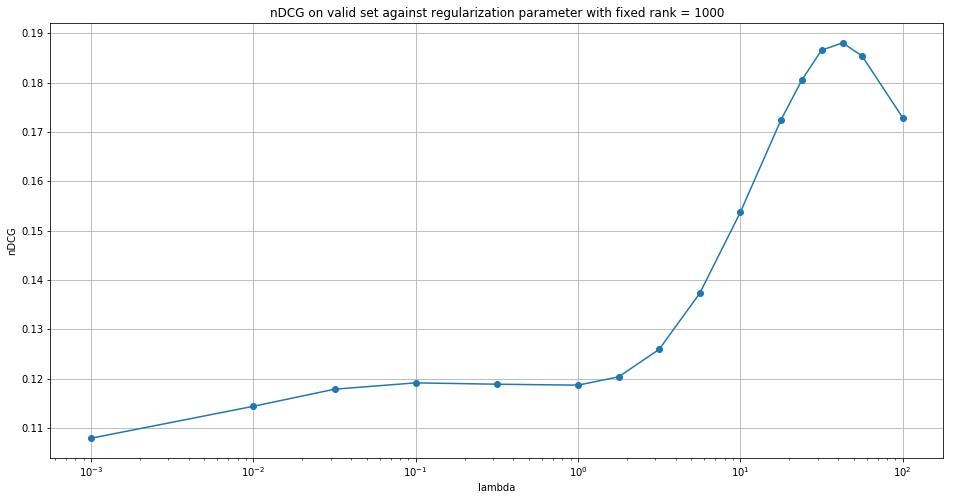

In [130]:
lambdas = 10.0**np.array([-3,-2,-1.5,-1,-.5,0,.25,.5,.75,1,1.25,1.38,1.5,1.63,1.75,2])
results_lambdas = [0.10788611035503735,
                   0.11436163803577458,
                   0.11782913300295363,
                   0.1191163663043079,
                   0.11884434477470304,
                   0.11865197245348003,
                   0.12033622367545528,
                   0.1259123988045788,
                   0.1372909700291726,
                   0.15371081481498228,
                   0.1724267396625802,
                   0.18059334112765055, #1.38
                   0.18658400992379232,
                   0.18806980325101336, #1.63
                   0.1854190564487339,
                   0.17290294769112938]
plt.semilogx(lambdas,results_lambdas,'-o')
plt.title("nDCG on valid set against regularization parameter with fixed rank = 1000")
plt.xlabel('lambda')
plt.ylabel('nDCG')
plt.grid()
plt.savefig('lambda.eps')

# 2. Rank=n_factor param. search for best nDCG

In [129]:
#2 rank search: 
ranks = [3000]
result_ranks = np.zeros(len(ranks))
for i in range(len(ranks)):
    result_ranks[i] = run(lamm=10.**(1.63),n_factorss=ranks[i],n_recommendations=100)

reading data from ./train.txt
read data file in 0.1453869342803955
weighting matrix by bm25_weight
training model als
trained model 'als' in 1239.51
generated recommendations in 76.06
0.18804660307683008
nDCG for rank=3000 and lambda=42.65795188015925 is : 0.18804660307683008


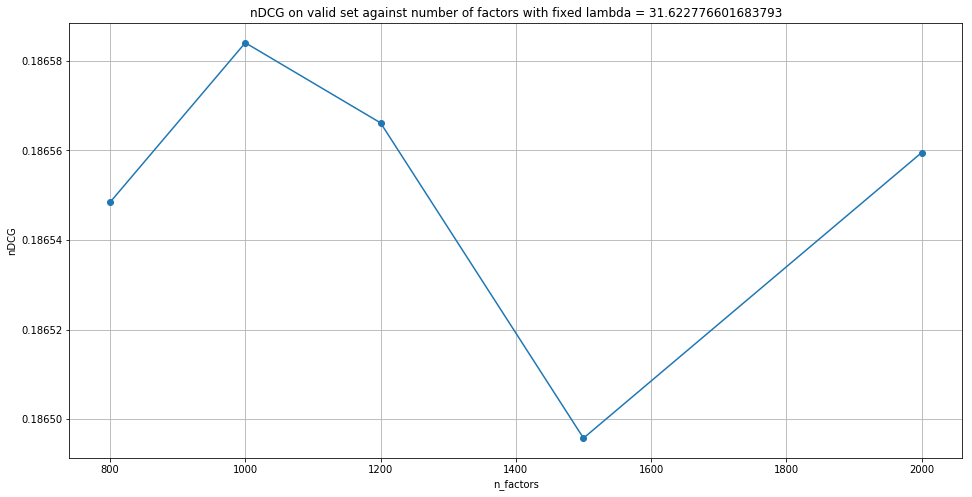

In [131]:
ranks = [800,1000,1200,1500,2000]
results_ranks = [0.18654839881565455,
                 0.18658400992379232,
                 0.1865661250706114,
                 0.18649575185659087,
                 0.18655949522763862]
plt.plot(ranks,results_ranks,'-o')
plt.title("nDCG on valid set against number of factors with fixed lambda = {}".format(10.**(1.5)))
plt.xlabel('n_factors')
plt.ylabel('nDCG')
plt.grid()
plt.savefig('rank.eps')

# best rank = 1000 with lamb 10.**(1.5)
# best rank = ?    with lamb 10.**(1.63)